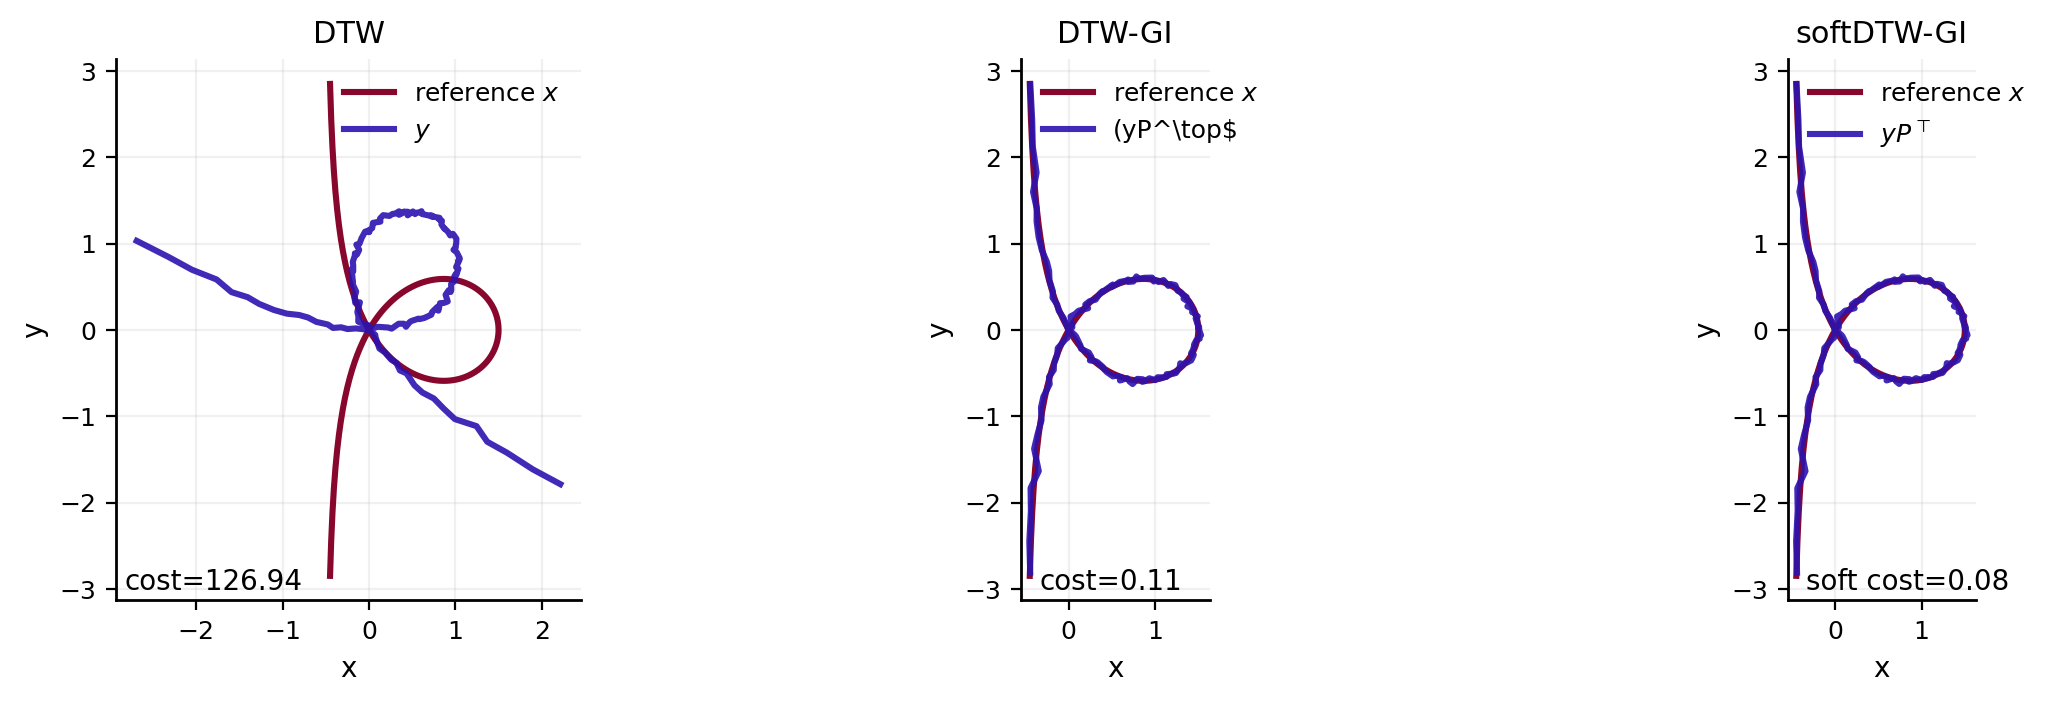

In [24]:
import numpy as np
import matplotlib.pyplot as plt


import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from dtw_gi.dtw.backend import compute_dtw_path
from dtw_gi import dtw_gi, dtw_gi_multistart
from dtw_gi import soft_dtw_gi
from data import make_one_folium, get_rot2d



plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
})



def plot_traj(ax, ts, *, label=None, lw=2.2, alpha=1.0, color=None):
    ax.plot(
        ts[:, 0],
        ts[:, 1],
        lw=lw,
        alpha=alpha,
        color=color,
        label=label,
    )


def plot_alignment_geometry_with_softdtw(
    *,
    T=140,
    noise_std=0.02,
    alpha=np.pi / 3,
    seed=0,
    backend="tslearn",
):
    rng = np.random.default_rng(seed)

    x = make_one_folium(sz=T, noise=0.0)
    R = get_rot2d(alpha)
    y = x @ R.T + noise_std * rng.standard_normal(x.shape)

    _, cost_dtw = compute_dtw_path(x, y, backend=backend) 



    res_gi = dtw_gi_multistart(
        x, y,
        max_iter=30,
        n_random_starts=5,
        seed=seed,
        backend=backend,
        verbose=False,
    )
    P_gi = res_gi.P
    yP = y @ P_gi.T
    yP_dtw = yP 



    res_soft = soft_dtw_gi(
        x, y,
        gamma=0.01,
        max_iter=150,
        lr=0.01,
        early_stopping_patience=10,
        verbose=False,
    )

    P_soft = res_soft.P
    yP_soft = y @ P_soft.T

    yP_soft_dtw = yP_soft 

    fig, axes = plt.subplots(1, 3, figsize=(11.5, 3.4), constrained_layout=True)

    for ax in axes:
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.18, linewidth=0.8)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    # DTW
    ax = axes[0]
    ax.set_title("DTW")
    plot_traj(ax, x, label ="reference $x$", color = "#87072d")
    plot_traj(ax, y, label =r"$y$", alpha=0.9, color = "#2b13af")
    ax.legend(frameon=False)
    ax.text(0.02, 0.02, f"cost={cost_dtw:.2f}", transform=ax.transAxes)

    # DTW-GI 
    ax = axes[1]
    ax.set_title("DTW-GI")
    plot_traj(ax, x, label ="reference $x$", color = "#87072d")
    plot_traj(ax, yP_dtw, label =r"(yP^\top$", alpha=0.9, color = "#2b13af")
    ax.legend(frameon=False)
    ax.text(
        0.1, 0.02,
        f"cost={res_gi.cost:.2f}",
        transform=ax.transAxes
    )

    # softDTW-GI 
    ax = axes[2]
    ax.set_title("softDTW-GI")
    plot_traj(ax, x, label ="reference $x$", color = "#87072d")
    plot_traj(ax, yP_soft_dtw, label =r"$yP^\top$", alpha=0.9, color= "#2b13af")
    ax.legend(frameon=False)
    ax.text(
        0.1, 0.02,
        f"soft cost={res_soft.cost:.2f}",
        transform=ax.transAxes
    )

    plt.show()


plot_alignment_geometry_with_softdtw(
    T=140,
    noise_std=0.02,
    alpha=np.pi / 3,
    seed=0,
    backend="tslearn",
)
